# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by installing and importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
#installing dependencies
!pip -q install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
from maddpg_agents import MultiAgent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
from unityagents import UnityEnvironment

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [4]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Train the agents

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
SOLVED_SCORE = 0.5
CONSEC_EPISODES = 100
PRINT_EVERY = 10
ADD_NOISE = True
BUILD_BUFFER = 100

In [8]:
multi_agent = MultiAgent(state_size, action_size, num_agents=2, random_seed=33)

In [9]:
def maddpg(n_episodes=2000, max_t=1000):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=CONSEC_EPISODES)
    scores_all = []
    moving_average = []
    already_solved = False    

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        multi_agent.reset()
        scores = np.zeros(num_agents)
        while True:
            if i_episode < BUILD_BUFFER:
                actions = (2 * np.random.rand(2, action_size) - 1.0).flatten()
            else:
                actions = multi_agent.get_actions(states, ADD_NOISE)           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            multi_agent.step(states, actions, rewards, next_states, done) #both agents learn
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # print results
        if i_episode % PRINT_EVERY == 0:
            print('Episodes {:d}-{:d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))

        # determine if environment is solved and keep best performing models
        if moving_average[-1] >= SOLVED_SCORE:
            print('<-- Environment solved in {:d} episodes! \
            \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                i_episode, moving_average[-1], CONSEC_EPISODES))
            # save weights
            torch.save(multi_agent.maddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(multi_agent.maddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(multi_agent.maddpg_agents[1].actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(multi_agent.maddpg_agents[1].critic_local.state_dict(), 'checkpoint_critic_1.pth')
            break
            
    return scores_all, moving_average

In [10]:
scores, avg = maddpg(5000, 2000)

Episodes 0-10	Max Reward: 0.000	Moving Average: 0.000
Episodes 10-20	Max Reward: 0.100	Moving Average: 0.010
Episodes 20-30	Max Reward: 0.100	Moving Average: 0.010
Episodes 30-40	Max Reward: 0.100	Moving Average: 0.010
Episodes 40-50	Max Reward: 0.100	Moving Average: 0.016
Episodes 50-60	Max Reward: 0.300	Moving Average: 0.022
Episodes 60-70	Max Reward: 0.100	Moving Average: 0.023
Episodes 70-80	Max Reward: 0.200	Moving Average: 0.026
Episodes 80-90	Max Reward: 0.100	Moving Average: 0.026
Episodes 90-100	Max Reward: 0.200	Moving Average: 0.025
Episodes 100-110	Max Reward: 0.000	Moving Average: 0.025
Episodes 110-120	Max Reward: 0.000	Moving Average: 0.023
Episodes 120-130	Max Reward: 0.000	Moving Average: 0.022
Episodes 130-140	Max Reward: 0.000	Moving Average: 0.021
Episodes 140-150	Max Reward: 0.000	Moving Average: 0.017
Episodes 150-160	Max Reward: 0.000	Moving Average: 0.012
Episodes 160-170	Max Reward: 0.000	Moving Average: 0.009
Episodes 170-180	Max Reward: 0.000	Moving Average: 

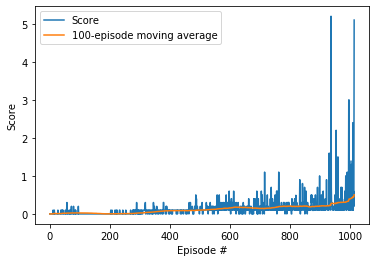

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(scores)), scores, label='Score')
plt.plot(range(len(scores)), avg, label='100-episode moving average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [12]:
fig.savefig('tennis_result2.png')

In [13]:
env.close()